# 載入函數

In [1]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
# torch api
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchsummary import summary
# device add gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")       # 使用Nvidia 顯卡
device

device(type='cpu')

# 模擬資料集

In [2]:
def linear_model(rseed=222, n_samples=30):
    " Generate data according to a linear model"
    np.random.seed(rseed)

    data = np.float32(np.random.normal(-1, 1, (n_samples, 2)))
    data[:n_samples // 2] -= 1.5
    data[n_samples // 2:] += 1.5

    labels = np.ones(n_samples, dtype = 'int64')
    labels[:n_samples // 2] = 0

    return data, labels

## 產生資料集

In [3]:
n_samples = 2000
X, y = linear_model(n_samples = n_samples)
print(X.dtype, y.dtype)

float32 int64


In [4]:
print('X: ', X[:5])
print('y: ', y[:5])

X:  [[-0.53657496 -2.2242303 ]
 [-2.0413418  -1.4987353 ]
 [-3.2638354  -1.7780724 ]
 [-3.4054694  -1.4981266 ]
 [-3.0207424  -2.1910472 ]]
y:  [0 0 0 0 0]


### 資料視覺化

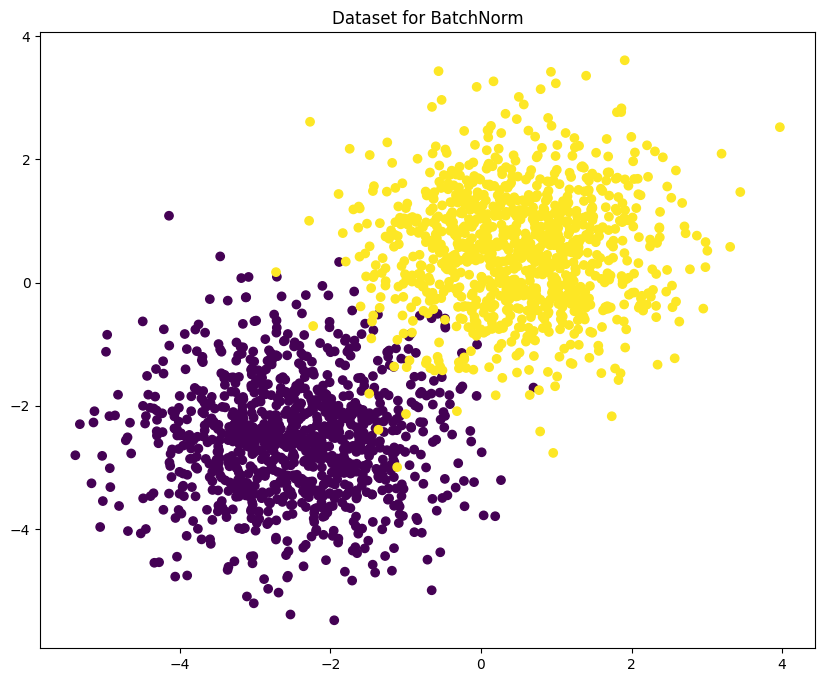

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = y)
plt.title('Dataset for BatchNorm')
plt.show()

## 切割訓練集 (Training set) 以及測試集 (testing set)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

print('Training data size: ', X_train.shape)
print('Testing data size: ', X_test.shape)

Training data size:  (1400, 2)
Testing data size:  (600, 2)


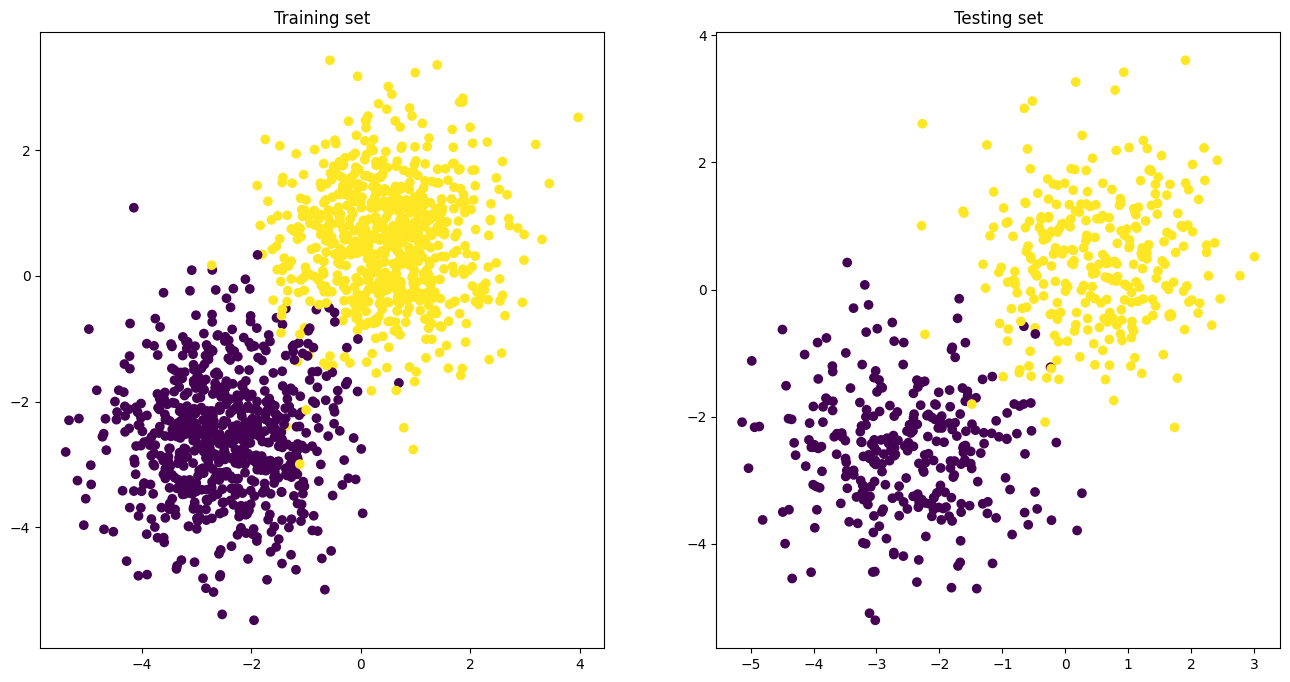

In [7]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(X_train[:,0], X_train[:,1], c = y_train)
plt.title('Training set')

plt.subplot(1,2,2)
plt.scatter(X_test[:,0], X_test[:,1], c = y_test)
plt.title('Testing set')
plt.show()

In [8]:
## 建立訓練的 generator，因為資料量可能會偏大，所以使用 generator 可以將所有資料分成 n 筆資料訓練一次。
class Custom_Generator(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data        # 輸入的訓練資料
        self.y_data = y_data        # 輸入訓練資料的標籤

    def __getitem__(self, index):
        data = self.X_data[index]
        target = self.y_data[index]

        return data,target

    def __len__(self):
        return len(self.X_data)     # 回傳資料集數量

In [9]:
# 1. 先呼叫我們寫好的Custom_Generator
train_data  = Custom_Generator(X_data = X_train, y_data = y_train)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
trainloader = DataLoader(train_data, batch_size=32,shuffle=True)

# 1. 先呼叫我們寫好的Custom_Generator
test_data  = Custom_Generator(X_data = X_test, y_data = y_test)

# 2. 呼叫pytorch的DataLoader來做批次動作，模型的輸入
testloader = DataLoader(test_data, batch_size=32,shuffle=False)

In [10]:
dataiter = iter(trainloader)   #迭代器
inputs,labels = next(dataiter)
print(inputs.dtype)
print(labels.dtype)

torch.float32
torch.int64


## 建立模型

In [11]:
class DNN(nn.Module):
    def __init__(self, input_shape, act = nn.ReLU(inplace=True)):
        super(DNN, self).__init__()
        self.fc = nn.Sequential(nn.Linear(in_features = input_shape, out_features = 32, bias = True),
                                act,
                                nn.Linear(in_features = 32, out_features = 64, bias = True),
                                act,
                                nn.Linear(in_features = 64, out_features = 128, bias = True),
                                act,
                                nn.Linear(in_features = 128, out_features = 64, bias = True),
                                act,)
        self.output = nn.Linear(in_features = 64, out_features = 2, bias = True)

    def forward(self,x):

        return self.output(self.fc(x))

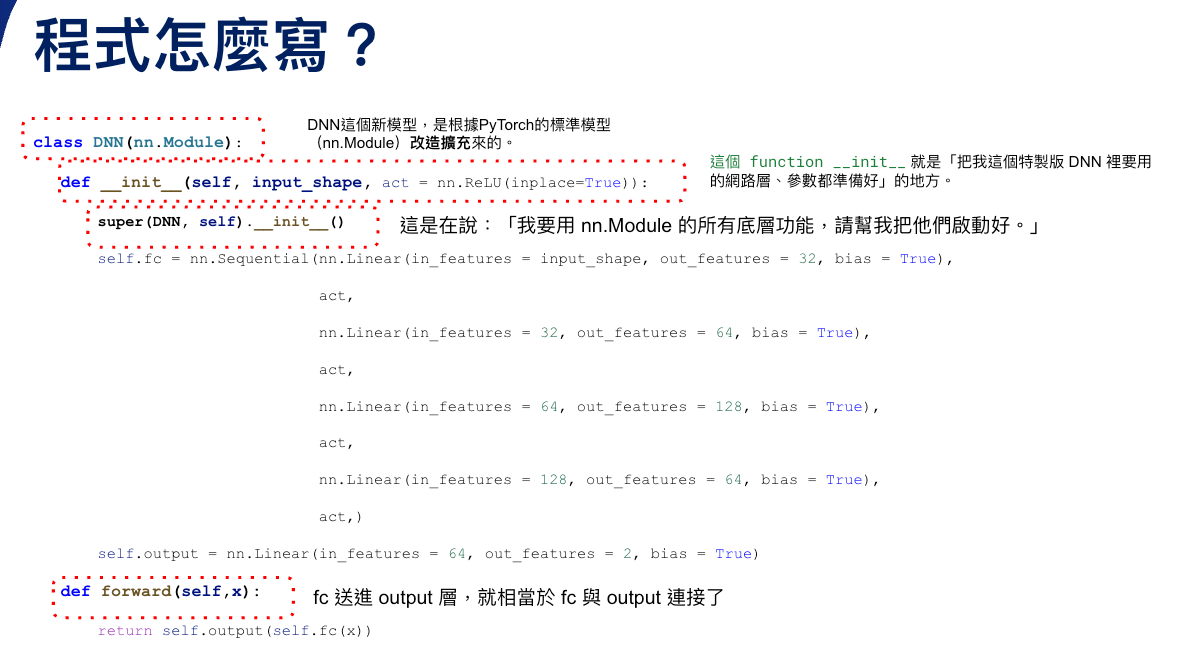

In [12]:
model = DNN(input_shape = 2, act = nn.Sigmoid()).to(device)
print(model)
summary(model, input_size = (2,))

DNN(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              96
           Sigmoid-2                   [-1, 32]               0
            Linear-3                   [-1, 64]           2,112
           Sigmoid-4                   [-1, 64]               0
            Linear-5                  [-1, 128]           8,320
           Sigmoid-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
           Si

## 訓練模型

* `optimizer`: 請使用 `sgd`, 其中 `momentum` 請設定 `0.9`
* `loss`: 請使用 `crossentropy`
* `epochs`: 請設定為 `200`
* `learning_rate`: 請設定為 `0.01`

In [13]:
# 設定loss function
criterion = nn.CrossEntropyLoss()

# learning rate
learning_rate = 0.01

# epochs數量
epochs = 200
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [14]:
Train_loss = []
Train_acc = []
valid_loss = []
valid_acc = []
# 第1步驟
for epoch in range(epochs):

    # 訓練階段
    model.train()
    running_loss = 0.0  # 訓練時的loss
    accuracy = 0.0
    total = 0.0

    # 第2步驟
    for times, data_train in enumerate(trainloader, 0):  # data_train會包括訓練的資料以及訓練的標籤

        # batch data input
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)

        # 第3步驟
        # Zero the parameter gradients
        optimizer.zero_grad()

        # model Feedforward
        output_train = model(inputs)

        # 第4步驟
        # Feed forward loss result
        loss = criterion(output_train, labels)

        # 第5步驟
        # backward update
        loss.backward()

        # 第6步驟
        # optimize
        optimizer.step()

        # 將每一筆資料的loss都加起來，假設有100筆資料就會有100個loss的結果
        # Compute loss
        running_loss += loss.item()

        # Compute Accuracy
        _, predicted = torch.max(output_train.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()

        # 當一個epoch結束後，顯示結果
        if times+1 == len(trainloader):
            print('[%d/%d, %d/%d] loss: %.3f, acc: %.3f' % (epoch+1,
                                                            epochs,times+1,
                                                            len(trainloader),
                                                            running_loss/len(trainloader),
                                                            accuracy / total),end = " ")
            Train_loss.append(running_loss/len(trainloader))
            Train_acc.append(accuracy / total)

    # 測試階段
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    total = 0.0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for times, data_test in enumerate(testloader, 0):
            # batch data input
            inputs, labels = data_test
            inputs, labels = inputs.to(device), labels.to(device)

            # model predict
            output_test = model(inputs)

            # Compute loss
            loss_t = criterion(output_test, labels)
            test_loss += loss_t.item()

            # Compute accuracy
            _, predicted = torch.max(output_test.data, 1)
            total += labels.size(0)
            test_accuracy += (predicted == labels).sum().item()

            if times+1 == len(testloader):
                print('test_loss: %.3f, test_acc: %.3f' % (test_loss / len(testloader),
                                                           test_accuracy / total))
                valid_loss.append(test_loss / len(testloader))
                valid_acc.append(test_accuracy / total)

print('Finished Training')


[1/200, 44/44] loss: 0.701, acc: 0.509 test_loss: 0.703, test_acc: 0.503
[2/200, 44/44] loss: 0.701, acc: 0.487 test_loss: 0.697, test_acc: 0.497
[3/200, 44/44] loss: 0.707, acc: 0.519 test_loss: 0.693, test_acc: 0.497
[4/200, 44/44] loss: 0.697, acc: 0.511 test_loss: 0.700, test_acc: 0.497
[5/200, 44/44] loss: 0.700, acc: 0.501 test_loss: 0.701, test_acc: 0.503
[6/200, 44/44] loss: 0.701, acc: 0.503 test_loss: 0.693, test_acc: 0.503
[7/200, 44/44] loss: 0.705, acc: 0.493 test_loss: 0.692, test_acc: 0.503
[8/200, 44/44] loss: 0.696, acc: 0.498 test_loss: 0.692, test_acc: 0.575
[9/200, 44/44] loss: 0.704, acc: 0.501 test_loss: 0.692, test_acc: 0.503
[10/200, 44/44] loss: 0.696, acc: 0.494 test_loss: 0.698, test_acc: 0.497
[11/200, 44/44] loss: 0.696, acc: 0.494 test_loss: 0.703, test_acc: 0.503
[12/200, 44/44] loss: 0.709, acc: 0.477 test_loss: 0.693, test_acc: 0.497
[13/200, 44/44] loss: 0.697, acc: 0.516 test_loss: 0.692, test_acc: 0.497
[14/200, 44/44] loss: 0.694, acc: 0.508 test_lo

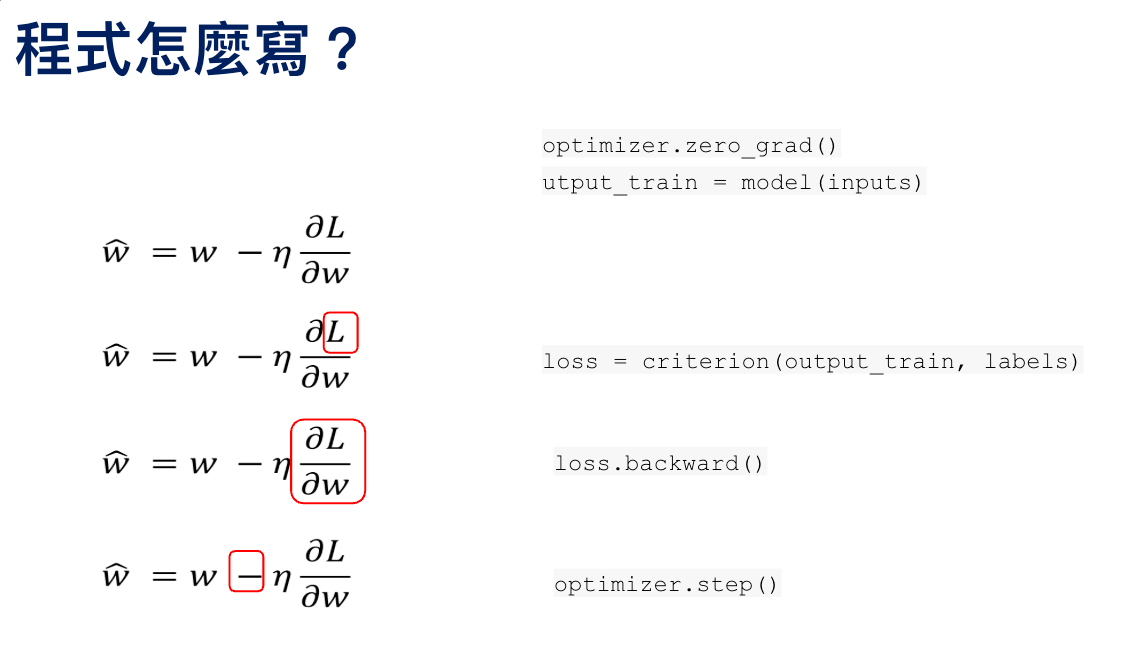

# 訓練結果評估

## Loss and accuracy

下圖顯示訓練集與測試集的 `loss` 以及 `accuracy`，隨著 `Epochs` 的變化狀況。

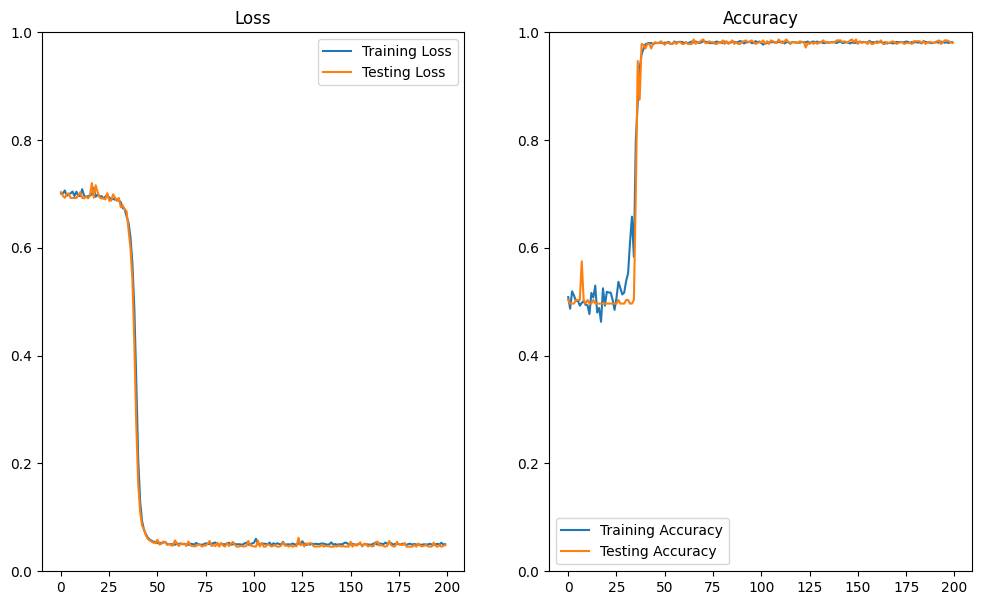

In [15]:
# 視覺化訓練過程
plt.figure(figsize=(12, 7))

# 繪製 Training loss 和 Validation loss
plt.subplot(121) # 121: 行(row)列(columns) 第幾個，一行二列第一個
plt.plot(range(len(Train_loss)), Train_loss, label='Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, label='Testing Loss')
plt.ylim(0.0,1.0)
plt.legend(loc='best')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(122) # 121: 行(row)列(columns) 第幾個，一行二列第二個
plt.plot(range(len(Train_acc)), Train_acc, label='Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, label='Testing Accuracy')
plt.ylim(0.0,1.0)
plt.legend(loc='best')
plt.title('Accuracy')

plt.show()

## Batch normalization

`Batch normalization`的作法就是對每一層的輸出都進行正規化到平均值為0、標準差為1的常態分佈。優點是:
1. 減緩梯度消失的問題
2. 可以加速學習
3. 不會過度依賴預設值

### 建立模型

In [16]:
class DNN_bn(nn.Module):
    def __init__(self, input_shape, act = nn.ReLU(inplace=True)):
        super(DNN_bn, self).__init__()
        self.fc = nn.Sequential(nn.Linear(in_features = input_shape, out_features = 32, bias = True),
                                nn.BatchNorm1d(num_features = 32),
                                act,
                                nn.Linear(in_features = 32, out_features = 64, bias = True),
                                nn.BatchNorm1d(num_features = 64),
                                act,
                                nn.Linear(in_features = 64, out_features = 128, bias = True),
                                nn.BatchNorm1d(num_features = 128),
                                act,
                                nn.Linear(in_features = 128, out_features = 64, bias = True),
                                nn.BatchNorm1d(num_features = 64),
                                act,)
        self.output = nn.Linear(in_features = 64, out_features = 2, bias = True)

    def forward(self,x):

        return self.output(self.fc(x))

In [17]:
model_bn = DNN_bn(input_shape = 2, act = nn.Sigmoid()).to(device)
print(model_bn)
summary(model_bn, input_size = (2,))

DNN_bn(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sigmoid()
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Sigmoid()
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Sigmoid()
  )
  (output): Linear(in_features=64, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]              96
       BatchNorm1d-2               

## 訓練模型

* `optimizer`: 請使用 `sgd`, 其中 `momentum` 請設定 `0.9`
* `loss`: 請使用 `crossentropy`
* `epochs`: 請設定為 `200`
* `learning_rate`: 請設定為 `0.01`

In [18]:
# 設定loss function
criterion = nn.CrossEntropyLoss()
# learning rate
learning_rate = 0.01
# epochs數量
epochs = 200
optimizer = optim.SGD(model_bn.parameters(), lr=learning_rate, momentum=0.9)

### 訓練模型

In [19]:
Train_loss = []
Train_acc = []
valid_loss = []
valid_acc = []
# 第1步驟
for epoch in range(epochs):

    # 訓練階段
    model_bn.train()
    running_loss = 0.0  # 訓練時的loss
    accuracy = 0.0
    total = 0.0

    # 第2步驟
    for times, data_train in enumerate(trainloader, 0):  # data_train會包括訓練的資料以及訓練的標籤

        # batch data input
        inputs, labels = data_train
        inputs, labels = inputs.to(device), labels.to(device)

        # 第3步驟
        # Zero the parameter gradients
        optimizer.zero_grad()

        # model Feedforward
        output_train = model_bn(inputs)

        # 第4步驟
        # Feed forward loss result
        loss = criterion(output_train, labels)
        # 第5步驟
        # backward update
        loss.backward()

        # 第6步驟
        # optimize
        optimizer.step()

        # 將每一筆資料的loss都加起來，假設有100筆資料就會有100個loss的結果
        # Compute loss
        running_loss += loss.item()

        # Compute Accuracy
        _, predicted = torch.max(output_train.data, 1)
        total += labels.size(0)
        accuracy += (predicted == labels).sum().item()

        # 當一個epoch結束後，顯示結果
        if times+1 == len(trainloader):
            print('[%d/%d, %d/%d] loss: %.3f, acc: %.3f' % (epoch+1,
                                                            epochs,times+1,
                                                            len(trainloader),
                                                            running_loss/len(trainloader),
                                                            accuracy / total),end = " ")
            Train_loss.append(running_loss/len(trainloader))
            Train_acc.append(accuracy / total)

    # 測試階段
    model_bn.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    total = 0.0
    with torch.no_grad(): # disable gradient calculation for efficiency
        for times, data_test in enumerate(testloader, 0):
            # batch data input
            inputs, labels = data_test
            inputs, labels = inputs.to(device), labels.to(device)

            # model predict
            output_test = model_bn(inputs)

            # Compute loss
            loss_t = criterion(output_test, labels)
            test_loss += loss_t.item()

            # Compute accuracy
            _, predicted = torch.max(output_test.data, 1)
            total += labels.size(0)
            test_accuracy += (predicted == labels).sum().item()

            if times+1 == len(testloader):
                print('test_loss: %.3f, test_acc: %.3f' % (test_loss / len(testloader),
                                                           test_accuracy / total))
                valid_loss.append(test_loss / len(testloader))
                valid_acc.append(test_accuracy / total)

print('Finished Training')


[1/200, 44/44] loss: 0.242, acc: 0.946 test_loss: 0.147, test_acc: 0.987
[2/200, 44/44] loss: 0.102, acc: 0.969 test_loss: 0.082, test_acc: 0.970
[3/200, 44/44] loss: 0.090, acc: 0.971 test_loss: 0.060, test_acc: 0.983
[4/200, 44/44] loss: 0.076, acc: 0.977 test_loss: 0.057, test_acc: 0.983
[5/200, 44/44] loss: 0.085, acc: 0.971 test_loss: 0.055, test_acc: 0.988
[6/200, 44/44] loss: 0.091, acc: 0.964 test_loss: 0.053, test_acc: 0.987
[7/200, 44/44] loss: 0.098, acc: 0.962 test_loss: 0.055, test_acc: 0.985
[8/200, 44/44] loss: 0.081, acc: 0.967 test_loss: 0.051, test_acc: 0.987
[9/200, 44/44] loss: 0.070, acc: 0.974 test_loss: 0.055, test_acc: 0.980
[10/200, 44/44] loss: 0.080, acc: 0.968 test_loss: 0.054, test_acc: 0.983
[11/200, 44/44] loss: 0.079, acc: 0.976 test_loss: 0.051, test_acc: 0.985
[12/200, 44/44] loss: 0.075, acc: 0.971 test_loss: 0.053, test_acc: 0.980
[13/200, 44/44] loss: 0.094, acc: 0.964 test_loss: 0.050, test_acc: 0.983
[14/200, 44/44] loss: 0.102, acc: 0.964 test_lo

In [20]:
# 在訓練完成之後，記得將模型儲存起來
model_name = 'BN.pth'
torch.save(model_bn, model_name)

### Loss and accuracy

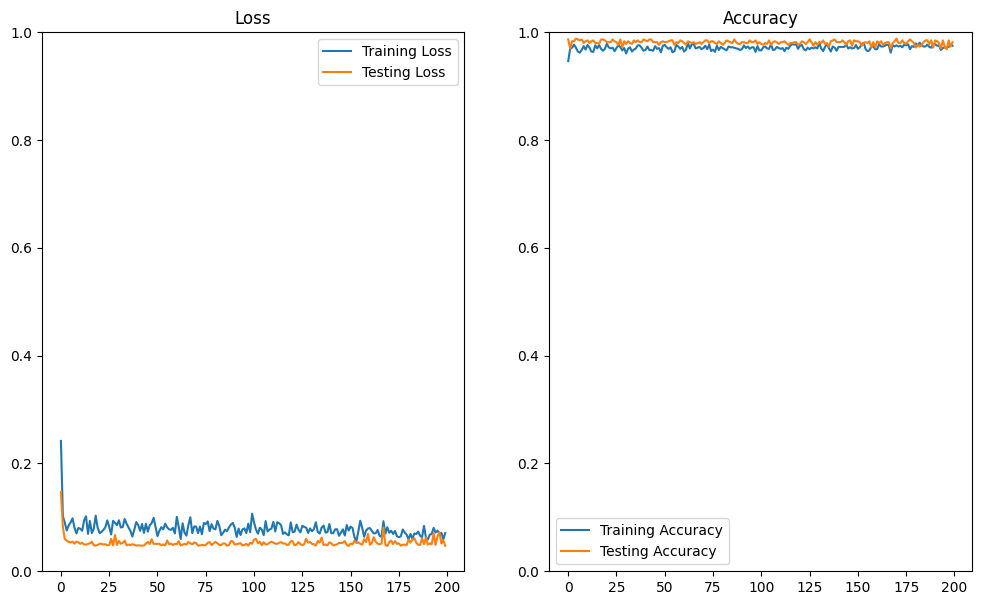

In [21]:
# 視覺化訓練過程
plt.figure(figsize=(12, 7))

# 繪製 Training loss 和 Validation loss
plt.subplot(121)
plt.plot(range(len(Train_loss)), Train_loss, label='Training Loss')
plt.plot(range(len(valid_loss)), valid_loss, label='Testing Loss')
plt.ylim(0.0,1.0)
plt.legend(loc='best')
plt.title('Loss')

# 繪製 Training accuracy 和 Validation accuracy
plt.subplot(122)
plt.plot(range(len(Train_acc)), Train_acc, label='Training Accuracy')
plt.plot(range(len(valid_acc)), valid_acc, label='Testing Accuracy')
plt.ylim(0.0,1.0)
plt.legend(loc='best')
plt.title('Accuracy')

plt.show()